# (Fantastic) Mochi Statistics and How to Analyze Them

Mochi services (more specifically margo) provide a monitoring system that outputs a lot of statistics about RPC and RDMA operations that happened during the execution of the service and applications using it. This notebook explains how to enable such monitoring, how to interpret the files it outputs, and how to convert them into formats like pandas dataframes to plot them.

## Enabling monitoring in Mochi services

The easiest way to enable monitoring in Mochi is by setting the `MARGO_ENABLE_MONITORING` environment variable before running your service and application. Margo will use default configuration values for its monitoring system and each process will produce a JSON file in the current working directory upon finalizing margo, with the name _"margo.\<hostname>.\<pid>.stats.json"_.

Alternatively, you may set the `monitor` field of the `margo_init_info` structure that you pass to `margo_init_ext` to `margo_default_monitor`. This will make margo enable monitoring by default, unless specified otherwise in the margo JSON configuration.

To configure the monitoring system, the `monitoring` section of the JSON configuration passed to `margo_init_ext` can be filled as follows.

```json
{
  ...
  "monitoring": {
    "config": {
      "filename_prefix": "test",
      "statistics": {
        "precision":9,
        "disable":false,
        "pretty_json":true
      },
      "time_series": {
        "disable":true
      }
    }
  }
}
```

The `filename_prefix` will be used for the output files, instead of the default _"margo"_ prefix. Here our statistics files will be named _"test.\<hostname>.\<pid>.stats.json"_. The `precision` field indicates the number of digits to display when outputing the statistics (9 is the default). The `disable` field can be used to quickly disable statistics monitoring. `pretty_json` tells the monitoring system to output "human-readable" JSON (i.e. with indentation and line breaks).

Once monitoring is enabled and you have generated a bunch of statistics files from your application (typically one per process), you may start processing them to extract relevant information. But first, a good understanding of how Mochi RPCs and RDMA transfers work is necessary.

## The JSON statistics format

Let's open one of the _.stats.json_ files. At the deepest levels of such a file are _statistics_ objects, in the following format.


```json
{
  "num":981,
  "min":0.000000238,
  "max":0.000176907,
  "avg":0.000000763,
  "var":0.000000031,
  "sum":0.000748873
}
```

These objects contain the number of samples (_num_), the minimum and maximum values observed (_min_ and _max_), the running average and variance (_avg_ and _var_), and the accumulated quantity (_sum_).

### Progress loop statistics

At the beginning of the file, we find the following JSON object.

```json
{
  "address":"na+sm://28885-0",
  "progress_loop":{
    "progress_with_timeout":{
      "num":3,
      "min":0.000004530,
      "max":0.134156227,
      "avg":0.083172719,
      "var":0.010552119,
      "sum":0.249518156
    },
    "progress_timeout_value_msec":{
      "num":3,
      "min":100.000000000,
      "max":100.000000000,
      "avg":100.000000000,
      "var":0.000000000,
      "sum":300.000000000
    },
    "progress_without_timeout":{
      "num":1524,
      "min":0.000000238,
      "max":0.000031948,
      "avg":0.000000459,
      "var":0.000000001,
      "sum":0.000699520
    },
    "trigger":{
      "num":8,
      "min":0.000000238,
      "max":0.000008821,
      "avg":0.000002861,
      "var":0.000000000,
      "sum":0.000022888
    }
  },
  ...
}
```

The `address` field provides the address of the margo instance that generated the file. Then, the `progress_loop` section provides statistics on the Mercury progress loop.

- `progress_with_timeout` tracks the timing of calls to `HG_Progress` (network progress in Mercury) with a non-zero timeout value;
- `progress_timeout_value_msec` tracks the value of the timeout from `HG_Progress` when such value is not 0;
- `progress_without_time` tracks the timing of calls to `HG_Progress` with a zero timeout value;
- `trigger` tracks the timing of calls to `HG_Trigger` (invokation of callbacks by Mercury), only for calls that actually triggered a callback.

### RPC statistics

The next section of the JSON file contains statistics on RPCs.

```json
{
  ...
  "rpcs": {
    "65535:65535:2924675071:65535": {
      "rpc_id": 2924675071,
      "provider_id": 65535,
      "parent_rpc_id": 65535,
      "parent_provider_id": 65535,
      "name": "echo",
      "origin": {
          ...
      },
      "target": {
          ...
      }
    },
    ...
  }
}
```

Statistics for an RPC are maintained per _callpath_. A callpath is composed of the RPC id, the provider id, the parent RPC id, and the parent provider id. For instance, if a process `A` sends an RPC `foo` with RPC id `12345` and provider id `42` to process `B`, and in its handler, process `B` sends an RPC `bar` with RPC id `67890` and provider id `33` to a process `C`, then statistics will show up in the files generated by `B` and `C` for a `bar` RPC with callpath `12345:42:67890:33`. If an RPC is called with no parent, its callpath will show as `65535:65535:<rpc_id>:<provider_id>` (the number `65535` is due to the way margo encodes RPC and provider ids internally). For instance, the files produced by `A` and `B` will have statistics for the callpath `65535:65535:12345:42`.

The _"origin"_ and _"target"_ sections group the statistics from an RPC as a sender (origin) and as a receiver (target). These sections contain subsections indexed by keys in the form `"sent to <address>"`, for the origin section, and `"received from <address>"`, for the target section. These subsections further group RPCs by the address of the remote peer that it sent to or received from.

Before we dive any further, let's recap: if process `A` sends an RPC `foo` with RPC id `12345` and provider id `42` to a process `B`, in the file created by `A` we will find a callpath `65535:65535:12345:42`, with an `origin` section containing a `send to <address of B>` section. In the file created by `B`, we will find a callpath `65535:65535:12345:42` with a `target` section containing a `received from <address of A>` section. These sections are further divided into operations, but first, we will need a little detour to better understand how Mochi RPCs work internally.

## Understanding RPCs in Mochi

A prerequisite to analyzing Mochi performance statistics is understanding how RPCs and RDMA (bulk transfers) work in Mochi services. This section will walk you through this.

### RPC from the sender's point of view (origin)

<img align="left" width="256" src="img/rpc-origin.svg" style="margin:0px 20px 0px 0px">

A process sending an RPC will start by creating an `hg_handle_t` object using `margo_create`. It will then call `margo_forward` (or one of its variants). Under the hood, a blocking _forward_ call is always executed as a non-blocking `margo_iforward` (or equivalent) call followed by a `margo_wait`. The `iforward` call will internally serialize the RPC's argument in a `set_input` step, before asking Mercury to send the RPC. Eventually, the RPC completes and the `forward_cb` callback is called by Mercury, unblocking the `wait` call. Finally to retrieve the data sent by the target of the RPC, `margo_get_output` is called.

The monitoring system in margo tracks statistics for each of these operations, apart from the `create` operation. For each of the operations described above and corresponding blocks on the figure on the left, the statistics JSON files will contain two entries: a _"relative_timestamp_from_X"_ entry, and a _"duration"_ entry. As their names indicate, the former contains statistics on the time between a certain operation and the beginning of the considered block. For instance the `iforward` block will have a _relative_timestamp_from_create_ and the latter contains statistics on the _duration_ of the block.

Having such detailed statistics enables computing more coarse-grain metrics. For instance, to compute the average amount of time a process spent calling a given RPC, we can simply add up the _avg_ fields of the `get_output`'s _relative_timestamp_from_forward_ entry, its _duration_ entry, and the `iforward`'s _relative_timestamp_from_create_. To compute just the time spent on a `margo_forward` for this RPC, we can add the `iforward_wait`'s _relative_timestamp_from_forward_ and _duration_.

Such detailed statistics also enable finding in which block our program spends the most of its time. Normally, we would want for the largest block to be `iforward_wait`, since this is the block that waits for the RPC response to come back. A long `set_input` or `get_output` operation may indicate a serialization overhead (if you transfer large amounts of data, consider using RDMA instead). A long `iforward` operation may indicate overhead in transferring the data over the network.


### RPC from the receiver's point of view (target)

<img align="left" width="256" src="img/rpc-target.svg" style="margin:0px 20px 0px 0px">

On the receiving end of an RPC, the first operation that is performed is the execution of the `handler` by the Mercury progress loop. This handler performs some checks on the RPC (such as finding out the Argobots pool in which the RPC should be executed) before creating a ULT for the RPC and pushing it into a pool. Eventually, the `ult` starts executing. Such an RPC will typically start by retrieveing the RPC's argument using `margo_get_input`, before performing some computations. It will then respond to the sender. Similarly to how margo treats `forward` calls as a non-blocking `iforward` followed by a `wait`, it also treats `margo_respond` as a `margo_irespond` followed by a `margo_wait`. The `irespond` step will first execute a `set_output` step to serialize the response's data into Mercury's buffer, before asking Mercury to send the response. Once Mercury has sent the response, it calls a `respond_cb` callback to unblock `margo_wait`.

Once again, the margo monitoring system will output statistics for all the operations, including a _relative_timestamp_from_X_ section and a _duration_ section. The `handler` section does not have a _relative_timestamp_from_X_ section because it is the first block that executes.

Note that the order of operations may not line up like in the figure. For instance, if the receiver process responds immediately to the sender, and get the input afterward, the `get_input` block will show up after the `irespond`, `set_output`, `irespond_wait`, and `respond_cb`. The `ult` could also create an anonymous ULT from which processing is done and from which `margo_respond` is eventually called, leading to the `ult` block terminating before the other blocks even start!

### Bulk transfers

<img align="left" width="256" src="img/bulk-transfer.svg" style="margin:0px 20px 0px 0px">

Bulk transfers are comparatively simpler to understand than RPCs. Once again, `margo_transfer` is actually decomposed into an `itransfer` and a `transfer_wait`, which blocks until an `itransfer_cb` callback is invoked by Mercury, as shown on the left figure.

In the margo monitoring system, in addition to the typical _duration_ and _relative_timestamp_from_X_ sections, bulk transfers also have a _size_ statistics measuring the size that was transferred. The monitoring system also further separates transfer statistics across remote address and type of operation (_pull_ and _push_).

Note: `margo_bulk_create` operations are also tracked. However, they are tracked separately from bulk transfers because they may not happen in the same context as the RPC that does the bulk transfer (for instance, a service could pre-create a set of bulk handles at start time).

## Back to JSON statistics

Now that you understand the various operations involved in sending and receiving an RPC, and in issuing a bulk transfer, it is time to go back to our JSON file. Navigating the `send to <address>` of one of our RPCs, in its `origin` section, we find the following.

```json
"sent to na+sm://28885-0": {
  "iforward": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_create": { ... statistics ... }
  },
  "forward_cb": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_forward_start": { ... statistics ... }
  },
  "iforward_wait": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_forward_end": { ... statistics ... }
  },
  "set_input": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_forward_start": { ... statistics ... }
  },
  "get_output": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_wait_end": { ... statistics ... }
  }
}
```

As explained above, each step has its _duration_ statistics and a _relative_timestamp_from_X_ statistics allowing us to position them with respect to the beginning or the end of an earlier step. All these timing statistics are expressed in seconds.

In the `target` section, we find `received from <address>` sections in the following format, once again containing the  _duration_ statistics and a _relative_timestamp_from_X_ statistics.

```json
"received from na+sm://28885-0": {
  "handler": {
    "duration": { ... statistics ... }
  },
  "ult": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_handler_start": { ... statistics ... }
  },
  "irespond": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_ult_start": { ... statistics ... }
  },
  "respond_cb": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_respond_start": { ... statistics ... },
  },
  "irespond_wait": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_respond_end": { ... statistics ... }
  },
  "set_output": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_respond_start": { ... statistics ... }
  },
  "get_input": {
    "duration": { ... statistics ... },
    "relative_timestamp_from_ult_start": { ... statistics ... }
  },
  "bulk": {
      ...
  }
}
```

The _"bulk"_ section contains statistics on bulk operations performed during the execution of this RPC. It is further decomposed as follows.

```json
"bulk": {
  "create": {
    "duration": { ... statistics ... },
    "size": { ... statistics ... }
  },
  "pull from na+sm://28885-0": {
    "itransfer": {
      "duration": { ... statistics ... },
      "size": { ... statistics ... }
    },
    "transfer_cb": {
      "duration": { ... statistics ... },
      "relative_timestamp_from_transfer_start": { ... statistics ... }
    },
    "itransfer_wait":{
      "duration": { ... statistics ... },
      "relative_timestamp_from_transfer_end": { ... statistics ... }
    }
  }
}
```

The _"create"_ entry gives statistics on duration and size (in bytes) of any `margo_bulk_create` operations called within the context of this RPC. Then come entries indexed by _"pull from \<address>"_ and _"push to \<address>"_ keys, which themselves contain the _"itransfer"_, _"transfer_cb"_ and _"itransfer_wait"_ steps. The rational behind providing the remote address with which the transfer is done is that this address may not be the same as the one that sent the RPC. One can imagine a process `A` creating a bulk handle and forwarding it to `B`, then `B` forwarding it to `C`, and `C` doing an transfer. This transfer will show up as a "pull from A" or "push to A" in the context of an RPC "received from B".

Finally, we may find in our JSON file a callpath of `65535:65535:65535:65535` with an empty RPC name and a _"bulk"_ section with bulk create statistics. This corresponds to `margo_bulk_create` operations that haven't been executed in the context of any RPC (i.e. typically on clients, or pre-created bulk handles on servers).

### Callpath inference

You may be surprised to see that the margo monitoring system is able to infer from which RPC bulk operations are done, even though these operations don't take the RPC handle as argument, or that `margo_forward` is called within the context of another RPC, even though it doesn't take the parent RPC handle.

Margo, in fact, makes a best attempt at infering the context in which these operations occure by relying on [Argobots keys](https://www.argobots.org/doxygen/latest_dev/d0/d5e/group__KEY.html) attached to ULTs. The downside of this is that such callpath inference is only possible if `margo_forward`, `margo_bulk_create` and `margo_bulk_transfer` are called within the ULT created by margo to execute the RPC. If this ULT itself creates other ULTs from which these functions are called, the callpath will be lost, unless the service implementer has been careful enough to call `margo_set_current_rpc_id` in the new ULTs to propagate the Argobots keys.

## Converting JSON statistics to Pandas dataframes

The JSON format can be useful for certain types of processing. For other types, such as making plot, we need to convert it into a tabular format. The code hereafter provides a `MochiStatistics` class that can ingest JSON files and aggregate their data into Pandas dataframes.

In [82]:
import json
import pandas as pd
import os
from collections import defaultdict
from typing import List


class MochiStatistics:
    
    def __init__(self, files: List[str] = []):
        self.origin_rpc_df = pd.DataFrame()
        self.target_rpc_df = pd.DataFrame()
        self.bulk_create_df = pd.DataFrame()
        self.bulk_transfer_df = pd.DataFrame()
        self.progress_loop_df = pd.DataFrame()
        for filename in files:
            self.add_file(filename)
    
    def add_file(self, filename: str):
        content = json.load(open(filename))
        rpcs = content['rpcs']
        progress_loop = content['progress_loop']
        address = content['address']
        self._add_origin_rpc_stats(filename, address, rpcs)
        self._add_target_rpc_stats(filename, address, rpcs)
        self._add_bulk_create_stats(filename, address, rpcs)
        self._add_bulk_transfer_stats(filename, address, rpcs)
        self._add_progress_loop_stats(filename, address, progress_loop)
        
    def _get_rpc_info(self, rpc: dict):
        return (rpc['name'], rpc['rpc_id'], rpc['provider_id'],
                rpc['parent_rpc_id'], rpc['parent_provider_id'])
    
    def _make_rpc_stats_df(self, filename: str, address: str, rpcs: dict,
                           section_name: str, peer_index: str):
        rpcs = {k:v for k, v in rpcs.items() if section_name in v}
        columns = defaultdict(list)
        index = []
        for rpc in rpcs.values():
            name, rpc_id, provider_id, parent_rpc_id, parent_provider_id = self._get_rpc_info(rpc)
            section = rpc[section_name]
            for peer_key, operations in section.items():
                peer_address = peer_key.split()[-1]
                operations = {k: v for k, v in operations.items() if k != 'bulk'}
                if len(operations) == 0: continue
                for operation, statsblock in operations.items():
                    for statsname, stats in statsblock.items():
                        for statstype, statsval in stats.items():
                            columns[(operation, statsname, statstype)].append(statsval)
                index.append((filename, address, name, rpc_id, provider_id,
                              parent_rpc_id, parent_provider_id, peer_address))
        index = pd.MultiIndex.from_tuples(index,
            names=['file', 'address', 'name', 'rpc_id', 'provider_id',
                   'parent_rpc_id', 'parent_provider_id', peer_index])
        df = pd.DataFrame(columns, index=index)
        df.columns.name = ('operation', 'category', 'statistics')
        return df
        
    def _add_origin_rpc_stats(self, filename: str, address: str, rpcs: dict):
        df = self._make_rpc_stats_df(filename, address, rpcs, 'origin', 'sent_to')
        self.origin_rpc_df = pd.concat([self.origin_rpc_df, df])
    
    def _add_target_rpc_stats(self, filename: str, address: str, rpcs: dict):
        df = self._make_rpc_stats_df(filename, address, rpcs, 'target', 'received_from')
        self.target_rpc_df = pd.concat([self.target_rpc_df, df])

    def _add_bulk_create_stats(self, filename: str, address: str, rpcs: dict):
        rpcs = {k:v for k, v in rpcs.items() if 'target' in v}
        columns = defaultdict(list)
        index = []
        for rpc in rpcs.values():
            name, rpc_id, provider_id, parent_rpc_id, parent_provider_id = self._get_rpc_info(rpc)
            target = rpc['target']
            for received_from, operations in target.items():
                if 'bulk' not in operations: continue
                if 'create' not in operations['bulk']: continue
                create = operations['bulk']['create']
                received_from_address = received_from.split()[-1]
                for statsname, stats in create.items():
                    for statstype, statsval in stats.items():
                        columns[('bulk_create', statsname, statstype)].append(statsval)
                index.append((filename, address, name, rpc_id, provider_id,
                              parent_rpc_id, parent_provider_id, received_from_address))
        index = pd.MultiIndex.from_tuples(index,
            names=['file', 'address', 'name', 'rpc_id', 'provider_id',
                   'parent_rpc_id', 'parent_provider_id', 'received_from'])
        df = pd.DataFrame(columns, index=index)
        df.columns.name = ('operation', 'category', 'statistics')
        self.bulk_create_df = pd.concat([self.bulk_create_df, df])
    
    def _add_bulk_transfer_stats(self, filename: str, address: str, rpcs: dict):
        rpcs = {k:v for k, v in rpcs.items() if 'target' in v}
        columns = defaultdict(list)
        index = []
        for rpc in rpcs.values():
            name, rpc_id, provider_id, parent_rpc_id, parent_provider_id = self._get_rpc_info(rpc)
            target = rpc['target']
            for received_from, operations in target.items():
                if 'bulk' not in operations: continue
                bulk = operations['bulk']
                if 'create' in bulk:
                    del bulk['create']
                if len(bulk) == 0: continue
                received_from_address = received_from.split()[-1]
                for transfer_key, transfer_stats in bulk.items():
                    transfer_type, _, peer_address = transfer_key.split()
                    for bulk_operation, statsblock in transfer_stats.items():
                        for statsname, stats in statsblock.items():
                            for statstype, statsval in stats.items():
                                columns[(bulk_operation, statsname, statstype)].append(statsval)
                    index.append((filename, address, name, rpc_id, provider_id,
                                  parent_rpc_id, parent_provider_id, received_from_address,
                                  transfer_type, peer_address))
        index = pd.MultiIndex.from_tuples(index,
            names=['file', 'address', 'name', 'rpc_id', 'provider_id',
                   'parent_rpc_id', 'parent_provider_id', 'received_from',
                   'transfer_type', 'remote_address'])
        df = pd.DataFrame(columns, index=index)
        df.columns.name = ('operation', 'category', 'statistics')
        self.bulk_transfer_df = pd.concat([self.bulk_transfer_df, df])
    
    def _add_progress_loop_stats(self, filename: str, address: str, progress_loop: dict):
        columns = defaultdict(list)
        for statsblock, stats in progress_loop.items():
            for statskey, statsval in stats.items():
                columns[(statsblock, statskey)].append(statsval)
        index = pd.MultiIndex.from_tuples([(filename, address)], names=['file', 'address'])
        df = pd.DataFrame(columns, index=index)
        df.columns.name = ('category', 'statistics')
        self.progress_loop_df = pd.concat([self.progress_loop_df, df])

The `MochiStatistics` object can be used as follows. The `add_file` function may be called to add more files later on.

In [85]:
stats = MochiStatistics(files=['data/test.ubuntu-vm.3384.stats.json', 'data/test.ubuntu-vm.3385.stats.json'])
stats.add_file('data/test.ubuntu-vm.3386.stats.json')

A `MochiStatistics` instance maintains the following five dataframes:

- `progress_loop_df` contains statistics on the Mercury progress loop, including durations of progress with and without timeout, duration of triggers, and timeout values (in milliseconds). This dataframe is indexed by filename and address. Columns are organized in two levels: category (_progress_with_timeout_, _trigger_, etc.), and statistics (_avg_, _min_, _max_, etc.).
- `origin_rpc_df` contains statistics on all the RPC operations at their source. This dataframe is indexed by filename, address, RPC name, RPC id, provider id, parent RPC id, parent provider id, and receiver address. Columns are organized in three levels: operation (_iforward_, _set_input_, etc.), category (_duration_, _relative_timestamp_from_X_, etc.), and statistics (_avg_, _min_, _max_, etc.).
- `target_rpc_df` contains statistics on all the RPC operarions at their destination. This dataframe is indexed by filename, address, RPC name, RPC id, provider id, parent RPC id, parent provider id, and sender address. Columns are organized in three levels: operation (_iforward_, _set_input_, etc.), category (_duration_, _relative_timestamp_from_X_, etc.), and statistics (_avg_, _min_, _max_, etc.).
- `bulk_create_df` contains statistics on all the bulk creation operations. It is organized in a way similar to `target_rpc_df`.
- `bulk_transfer_df` contains statistics on all the bulk transfer operations. It is organized in a way similar to `target_rpc_df` but is further indexed by transfer type (_push_ or _pull_) and remote address.

Let's take a look at one of these dataframes:

In [87]:
stats.target_rpc_df

handler  \
                                                                                                                            duration   
                                                                                                                                 num   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from             
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0        1   
                                                                               2924675071 65535              na+sm://3384-0        1   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0        1   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0        1   
                                                                               2924675071 42                 na+sm://3386-0        1   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  min   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000007   
                                                                               2924675071 65535              na+sm://3384-0  0.000003   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000003   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000008   
                                                                               2924675071 42                 na+sm://3386-0  0.000003   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  max   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000007   
                                                                               2924675071 65535              na+sm://3384-0  0.000003   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000003   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000008   
                                                                               2924675071 42                 na+sm://3386-0  0.000003   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  avg   
file                 

These tables are pretty wide and Jupyter will most likely cut a good chunk of it. We can look at the column names to see what we have at our disposal:

In [94]:
stats.target_rpc_df.columns

MultiIndex([(      'handler',                               'duration', 'num'),
            (      'handler',                               'duration', 'min'),
            (      'handler',                               'duration', 'max'),
            (      'handler',                               'duration', 'avg'),
            (      'handler',                               'duration', 'var'),
            (      'handler',                               'duration', 'sum'),
            (          'ult',                               'duration', 'num'),
            (          'ult',                               'duration', 'min'),
            (          'ult',                               'duration', 'max'),
            (          'ult',                               'duration', 'avg'),
            (          'ult',                               'duration', 'var'),
            (          'ult',                               'duration', 'sum'),
            (          'ult',  'relative

Let's imagine we want to select the total duration of the _get_input_ operation, we would do:

In [102]:
stats.target_rpc_df['get_input']["duration"]["sum"]

file                                 address         name  rpc_id      provider_id  parent_id   parent_provider_id  received_from 
test/test.ubuntu-vm.3384.stats.json  na+sm://3384-0  echo  2924675071  65535        65535       65535               na+sm://3384-0    0.000005
                                                                                    2924675071  65535               na+sm://3384-0    0.000002
test/test.ubuntu-vm.3385.stats.json  na+sm://3385-0  echo  2924675071  65535        65535       65535               na+sm://3385-0    0.000002
test/test.ubuntu-vm.3386.stats.json  na+sm://3386-0  echo  2924675071  42           65535       65535               na+sm://3386-0    0.000006
                                                                                    2924675071  42                  na+sm://3386-0    0.000002
Name: sum, dtype: float64

This gives us a series containing data for all the files, RPCs, provider id, etc. which we could want to sum further:

In [103]:
stats.target_rpc_df['get_input']["duration"]["sum"].sum()

1.7403999999999998e-05

We can also select all the "avg" sub-columns:

In [105]:
stats.target_rpc_df.loc[:, (slice(None), slice(None), "avg")]

handler  \
                                                                                                                             duration   
                                                                                                                                  avg   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000007   
                                                                               2924675071 65535              na+sm://3384-0  0.000003   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000003   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000008   
                                                                               2924675071 42                 na+sm://3386-0  0.000003   

                                                                                                                                  ult  \
                                                                                                                             duration   
                                                                                                                                  avg   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000147   
                                                                               2924675071 65535              na+sm://3384-0  0.000067   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000110   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000153   
                                                                               2924675071 42                 na+sm://3386-0  0.000070   

                                                                                                                                                                   \
                                                                                                                            relative_timestamp_from_handler_start   
                                                                                                                                                              avg   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from                                          
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0                              0.000013   
                                                                               2924675071 65535              na+sm://3384-0                              0.000005   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0                              0.000006   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0                              0.000014   
                                                                               2924675071 42                 na+sm://3386-0                              0.000004   

                                                                                                                             irespond  \
                                   

... or all the "duration" sub-columns:

In [108]:
stats.target_rpc_df.loc[:, (slice(None), "duration", slice(None))]

handler  \
                                                                                                                            duration   
                                                                                                                                 num   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from             
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0        1   
                                                                               2924675071 65535              na+sm://3384-0        1   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0        1   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0        1   
                                                                               2924675071 42                 na+sm://3386-0        1   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  min   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000007   
                                                                               2924675071 65535              na+sm://3384-0  0.000003   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000003   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000008   
                                                                               2924675071 42                 na+sm://3386-0  0.000003   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  max   
file                                address        name rpc_id     provider_id parent_id  parent_provider_id received_from              
test/test.ubuntu-vm.3384.stats.json na+sm://3384-0 echo 2924675071 65535       65535      65535              na+sm://3384-0  0.000007   
                                                                               2924675071 65535              na+sm://3384-0  0.000003   
test/test.ubuntu-vm.3385.stats.json na+sm://3385-0 echo 2924675071 65535       65535      65535              na+sm://3385-0  0.000003   
test/test.ubuntu-vm.3386.stats.json na+sm://3386-0 echo 2924675071 42          65535      65535              na+sm://3386-0  0.000008   
                                                                               2924675071 42                 na+sm://3386-0  0.000003   

                                                                                                                                       \
                                                                                                                                        
                                                                                                                                  avg   
file                 

## Plotting the statistics

Now that we have our data nicely organized in dataframes, we can start plotting it in various ways. For instance, let's build a dataframe containing the accumulated time spent in the ULT of the echo RPC:

In [109]:
ult_duration_sum_df = stats.target_rpc_df['ult']['duration']['sum']
ult_duration_sum_df

file                                 address         name  rpc_id      provider_id  parent_id   parent_provider_id  received_from 
test/test.ubuntu-vm.3384.stats.json  na+sm://3384-0  echo  2924675071  65535        65535       65535               na+sm://3384-0    0.000147
                                                                                    2924675071  65535               na+sm://3384-0    0.000067
test/test.ubuntu-vm.3385.stats.json  na+sm://3385-0  echo  2924675071  65535        65535       65535               na+sm://3385-0    0.000110
test/test.ubuntu-vm.3386.stats.json  na+sm://3386-0  echo  2924675071  42           65535       65535               na+sm://3386-0    0.000153
                                                                                    2924675071  42                  na+sm://3386-0    0.000070
Name: sum, dtype: float64

We will want to plot a bar chart with the address in the _x_ axis and the duration in the `y` axis. In the series above we find that some addresses have sent the RPC with different provider ids. We need to aggregate these lines.

In [113]:
series = ult_duration_sum_df.groupby("address").agg("sum")
series

address
na+sm://3384-0    0.000214
na+sm://3385-0    0.000110
na+sm://3386-0    0.000222
Name: sum, dtype: float64

We are now ready to plot the result:

<AxesSubplot: xlabel='address'>

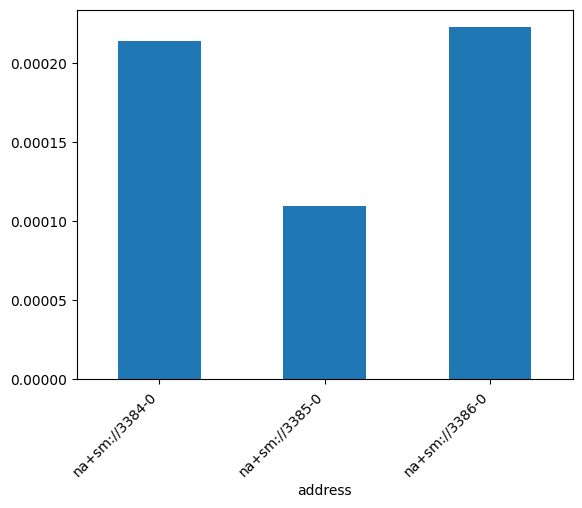

In [121]:
ax = series.plot.bar()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax

You are now ready to analyze your own Mochi statistics files! If this workflow made you think that a dashboard with typical plots could be useful, don't worry, we are working on that already! For now, feel free to use this notebook as a starting point for your own analysis!